<a href="https://colab.research.google.com/github/LuisaBeccar/proyecto_nlp/blob/main/TP_DCIII_LuisaBeccarVarela_nlp_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

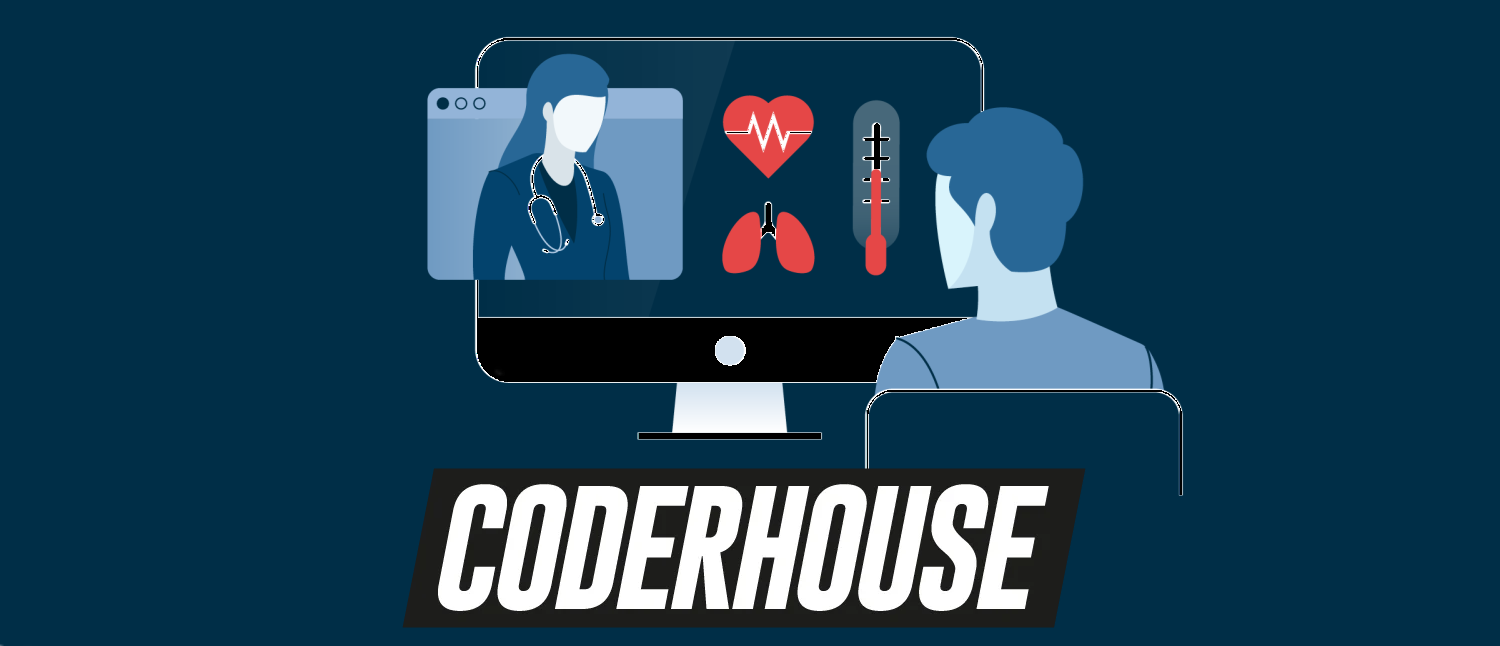

# CoderHouse: NLP & Deep Learning para la Ciencia de Datos
## Comision: 61195 - Nov-Dic 2024
## Luisa Beccar Varela

  ## Clasificación de enfermedades segun descripción de sintomas. <br>


**Introducción** <br>

Metas:<br>
  Combinar lo que aprendido  sobre el procesamiento de texto en lenguage natural y los modelos de clasificación de machine learning para desarrollar algoritmos capaces de clasificar los sintomas descripctos en especialidades, que podria aplicarse a nuevos sintomas introducidos por new inputs. <br>

**Contexto empresarial**<br>
 Un científico de datos en una gran empresa de telemedicina, que tiene miles de llamadas de pacientes que describen sus sintomas cada día.

La empresa quiere identificar de manera automatica la especialidad a la cual deberia deribar a cada pacinete que consulta de manera automatica segun la enfermedad que esté describiendo.

**Método**

Luego de un breve análisis del texto de síntomas, usaré herramientas de vectorizacion con distintos parametros (Count Vectorizer con stop words, lematizer y ngramas), modelos de machine learning para problemas de clasificacion: Logistic Regression, Random  Forest, Support Vector Machine y Gradient Boosting; cross validation con Stratified K fold, y busqueda de hiperparámetros con Halving Random Search.

Además, implementaré modelos de redes neuronales para mi problema de claificacion. Usare la librería Tensor Flow, y con ella distintos metodos, con embedding, convoluciones, pooling y LSTM.<br>
  
Finalmente priebo un modelo de redes neuronales con preentrenamiento mediante embedding y corpus de Clove para generacion de texto.<br>
  <br>
<br>

Dataset de [kaggle](www.kaggle.com/datasets/krish0202/symptom-based-disease-labeling-datasetcsv) que descargue en mi [github](https://github.com/LuisaBeccar/proyecto_nlp/blob/main/Symptom2DiseaseKaggle.csv) de 1200 registros.
<br>

Disclaimers:
  - Es una base bastante pequeña y esto afectara la capacidad de prediccion de nuevos registros.
  - No se sabe quien realizo la clasificacion de enfermedades por lo que la validez de las predicciones quedará entre otras cosas sujeta a si eso fue realizado correctamente.


In [ ]:
%%capture
# librerias

import pandas as pd
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, KFold, GridSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer
from nltk import word_tokenize
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
import matplotlib.pyplot as plt



# Procesamiento de Lenguaje Natural

### Preprocesamineto 1

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/LuisaBeccar/proyecto_nlp/refs/heads/main/Symptom2DiseaseKaggle.csv")
df.drop(columns="Unnamed: 0", inplace=True)
df.rename(columns={"text":"symptoms", "label":"illness"}, inplace=True)
df.head(3)

,illness,symptoms
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   illness   1200 non-null   object
 1   symptoms  1200 non-null   object
dtypes: object(2)
memory usage: 18.9+ KB


In [ ]:
df.symptoms.value_counts()
# veo que hay descripciones repetidas

,count
symptoms,
"I've been feeling extremely scratchy, sick, and worn out. In addition, I've lost weight and have a temperature. My urine is dark, and my skin has turned yellow. Additionally, I have been experiencing stomach pain.",4
I've been feeling really weak in my muscles and my neck has been really stiff. My joints have been swelling up and it's hard for me to move around without feeling stiff. Walking has been really painful too.,3
"I've been constipated and it's really hard to go to the bathroom. When I do go, it hurts and my stool has been bloody. I've also been having some pain in my butt and my anus has been really itchy and irritated.",3
"I've been experiencing stiffness and weakness in my neck muscles recently. Since my joints have grown, it's hard for me to walk without getting stiff. Additionally, walking has been extremely uncomfortable.",2
"Since I've been constipated, using the restroom has been quite challenging. When I do go, it aches and I've had blood in my stool. My anus has been quite itchy and irritating, and I've also been experiencing some discomfort in my butt.",2
...,...
"I've been experiencing severe weariness and a sickly sensation. My throat has been really painful and I've had a fairly severe cough. My nose has been quite stuffy, and I've had significant sinus pressure. I'm really miserable and extremely exhausted.",1
I've been feeling really sick and I've had a lot of fatigue. I've had a really bad cough and my throat has been really sore. I've had a lot of sinus pressure and my nose has been really congested. I just feel really run down and miserable.,1
"I've been quite exhausted and ill. My throat has been quite painful, and I've had a fairly nasty cough. I've got a lot of chills and a pretty high temperature. Simply put, I feel really run down and feeble.",1


In [ ]:
# elimino los duplicados
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1153 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   illness   1153 non-null   object
 1   symptoms  1153 non-null   object
dtypes: object(2)
memory usage: 27.0+ KB


In [ ]:
# cuento cuantas descripciones de cada illness hay
df.illness = df.illness.str.lower()
df.illness.value_counts()


,count
illness,
psoriasis,50
varicose veins,50
peptic ulcer disease,50
drug reaction,50
allergy,50
urinary tract infection,50
hypertension,50
diabetes,50
fungal infection,50


In [ ]:
#genero un dataframe de las enfermedades y cuantas de cada una hay
enfermedades = df.illness.value_counts().reindex(df.illness.value_counts().index)
enfermedades.info()

<class 'pandas.core.series.Series'>
Index: 24 entries, psoriasis to jaundice
Series name: count
Non-Null Count  Dtype
--------------  -----
24 non-null     int64
dtypes: int64(1)
memory usage: 384.0+ bytes


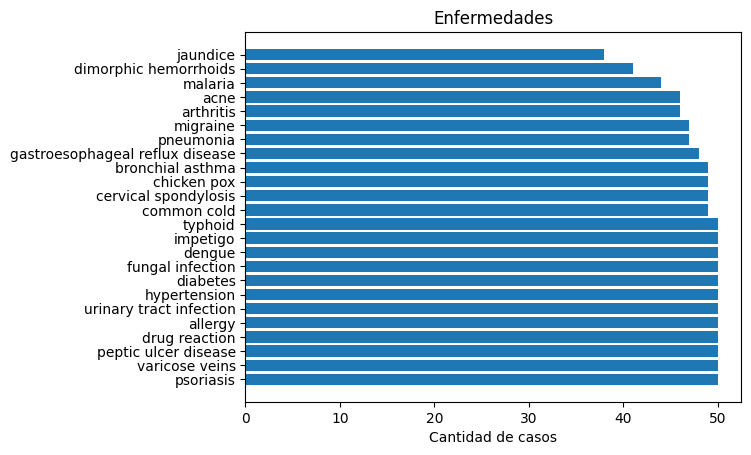

In [ ]:
#grafico cantidad de registros de cada enfermedad
fig = plt.barh(enfermedades.index, enfermedades.values)
plt.title("Enfermedades")
plt.xlabel("Cantidad de casos")
plt.show()

Mi dataset se compone de las columnas "illness" y "sypmptoms", tiene 1200 registros no nulos, pero que luego de quitar los duplicados quedaron 1153. Las "illness" son 24 categorias. Cada categoria tiene entre 50 y 38 descripciones de sintomas. La enfermedad que menos descripciones de sintomas tiene es "janudice" (ictericia) que tiene 38.

Para simplificar la clasificacion, mi problema voy a subclasificar estas enfermedades yo misma, de manera que me descargo la lista de enfermedades para estudiarla y escoger como subclasificarlas.

In [ ]:
enfermedades.to_csv("enfermedades.csv")

In [ ]:
#luego de hacer la clasificacion, subo el archivo csv creado

enf_clas = pd.read_csv("https://raw.githubusercontent.com/LuisaBeccar/proyecto_nlp/refs/heads/main/enfermedades_clasificadas.csv")
enf_clas.illness = enf_clas.illness.str.lower()
enf_clas.clasificacion = enf_clas.clasificacion.str.lower()
enf_clas

,illness,clasificacion
0,psoriasis,dermatology
1,varicose veins,dermatology
2,peptic ulcer disease,gastroenterology
3,drug reaction,dermatology
4,allergy,dermatology
5,urinary tract infection,infectology
6,hypertension,cronic disease
7,diabetes,cronic disease
8,fungal infection,infectology
9,dengue,infectology


In [ ]:
# mergeo el dataset de las descripciones e illness con el dataset de subclasificaciones para que me ponga una nueva columna con mi subclasificacion segun la ilness
df = pd.merge(df, enf_clas, on="illness", how="left")
# elimino la columna de illness que no voy a usar
df.drop(columns="illness", inplace=True)
df

,symptoms,clasificacion
0,I have been experiencing a skin rash on my arm...,dermatology
1,"My skin has been peeling, especially on my kne...",dermatology
2,I have been experiencing joint pain in my fing...,dermatology
3,"There is a silver like dusting on my skin, esp...",dermatology
4,"My nails have small dents or pits in them, and...",dermatology
...,...,...
1148,I'm shaking and trembling all over. I've lost ...,cronic disease
1149,"Particularly in the crevices of my skin, I hav...",cronic disease
1150,I regularly experience these intense urges and...,cronic disease
1151,"I have trouble breathing, especially outside. ...",cronic disease


In [ ]:
# quiero mirar como quedaron distribuidas mis categorias
clasificadas = df.clasificacion.value_counts().reindex(df.clasificacion.value_counts().index)
clasificadas

,count
clasificacion,
infectology,389
dermatology,296
cronic disease,242
gastroenterology,177
traumatology,49


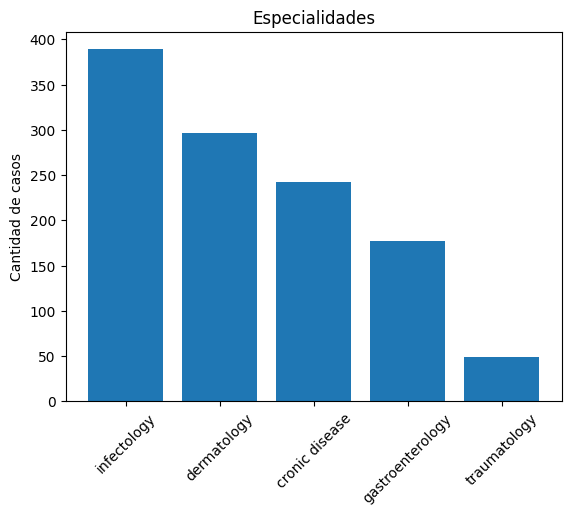

In [ ]:
import matplotlib.pyplot as plt

fig = plt.bar(clasificadas.index, clasificadas.values)
plt.xticks(rotation=45)
plt.title("Especialidades")
plt.ylabel("Cantidad de casos")
plt.show()

Elegí sublasificar las enfermedades en especialidades medicas. Se ve que están desbalanceadas, lo cual deberá ser tenido en cuenta mas adelante para el análisis.


### Analisis de tokens

Para seguir analizando el dataset, crearé un par de columnas con: <br>
  - las categorias encodeades, <br>
  - cada descripcion tokenizada, sin stopwords, caracteres especiales ni mayusculas <br>


In [ ]:
# encodear clasificacion

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["clasificacion_encoded"] = label_encoder.fit_transform(df.clasificacion)
df.head(2)

,symptoms,clasificacion,clasificacion_encoded
0,I have been experiencing a skin rash on my arm...,dermatology,1
1,"My skin has been peeling, especially on my kne...",dermatology,1


In [ ]:
%%capture
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# todo en minusculas y sacar stopwords
def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)

df["symptoms_tokenized"] = df.apply(lambda row: remove_stop_words(row['symptoms']), axis=1)

In [ ]:
df.head(2)

,symptoms,clasificacion,clasificacion_encoded,symptoms_tokenized
0,I have been experiencing a skin rash on my arm...,dermatology,1,experiencing skin rash arms legs torso past we...
1,"My skin has been peeling, especially on my kne...",dermatology,1,skin peeling especially knees elbows scalp pee...


In [ ]:
df = df.copy()

In [ ]:
df.to_csv("df_preprocesado.csv")

Analizando un poquito la diferencia entre el corpus de "syntoms" vs "symptoms_tokenized"...

In [ ]:
# Número total de palabras en el corpus original

num_words = sum(len(sentence) for sentence in df['symptoms'])
display(f"Número total de palabras en el corpus original: {num_words}")

# Número total de palabras en el corpus tokenizado

num_words = sum(len(sentence) for sentence in df['symptoms_tokenized'])
display(f"Número total de palabras en el corpus tokenizado: {num_words}")

'Número total de palabras en el corpus original: 197293'

'Número total de palabras en el corpus tokenizado: 125486'

Número total de palabras en el corpus original: 197293 <br>
Número total de palabras en el corpus tokenizado: 125486

Analizando cada categoria

In [ ]:
# separo cada especialidad en un dataset para usar luego
especialidades= ["cronic disease", "dermatology", "gastroenterology", "infectology", "traumatology"]

for i in especialidades:
  df_filtrado = df[df["clasificacion"] == i]
  df_filtrado.to_csv(f"{i}.csv")

In [ ]:
# abro los datasets y guardo en un objeto

cronic_disease = pd.read_csv("cronic disease.csv")
dermatology = pd.read_csv("dermatology.csv")
gastroenterology = pd.read_csv("gastroenterology.csv")
infectology = pd.read_csv("infectology.csv")
traumatology = pd.read_csv("traumatology.csv")

especialidades_csv = [cronic_disease, dermatology, gastroenterology, infectology, traumatology]

In [ ]:
# ordeno un poquito tods los df que quedaron con un indice mal

def remove0 (df):
  df.drop(columns="Unnamed: 0", inplace=True)
  return df

for es in especialidades_csv:
  remove0(es)

In [ ]:
  colores = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
  csv_color = dict(zip(especialidades, colores))

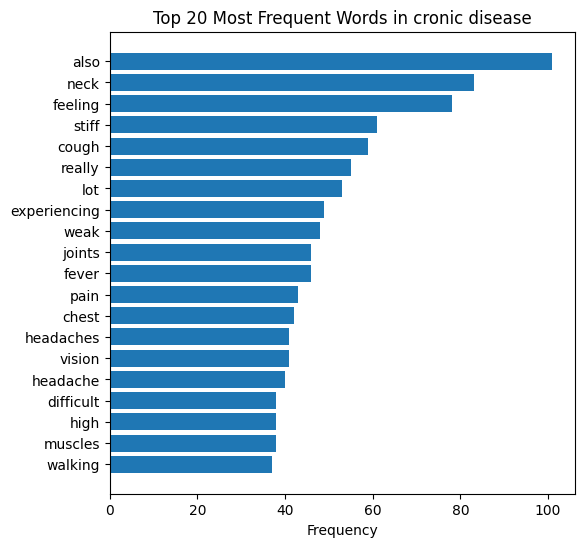

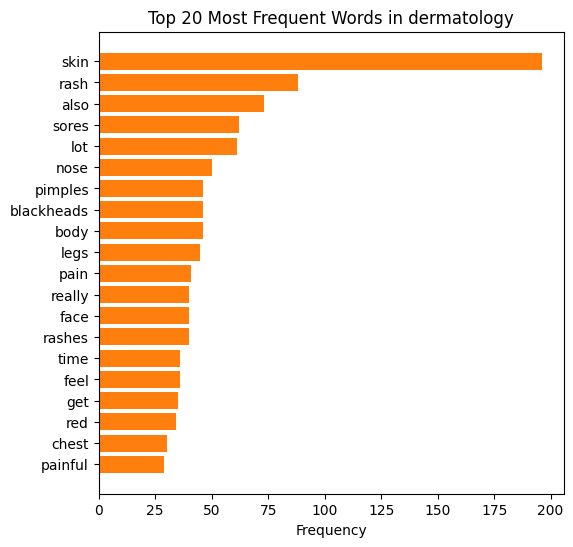

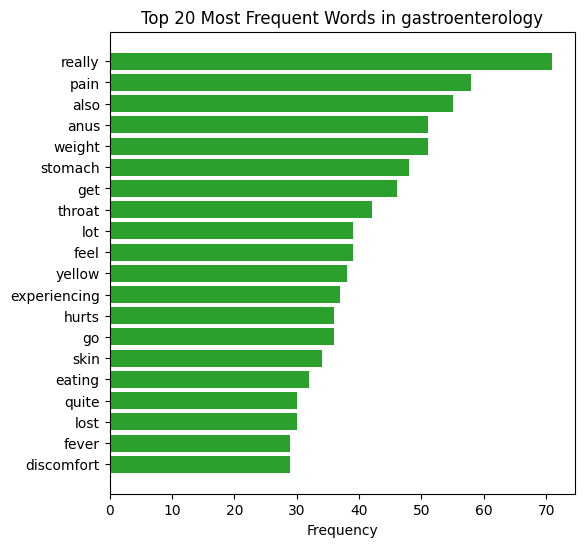

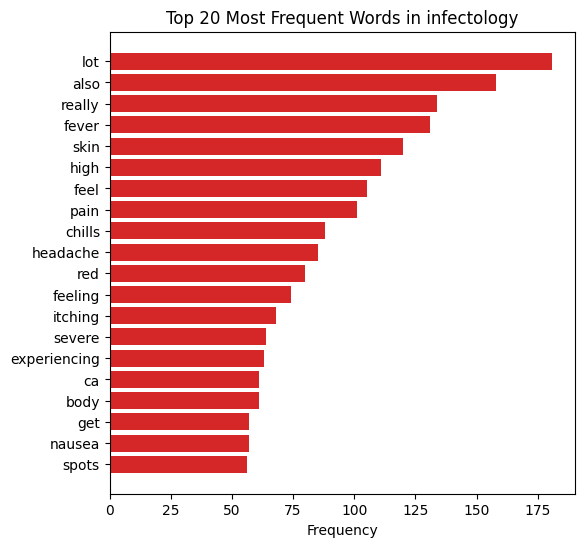

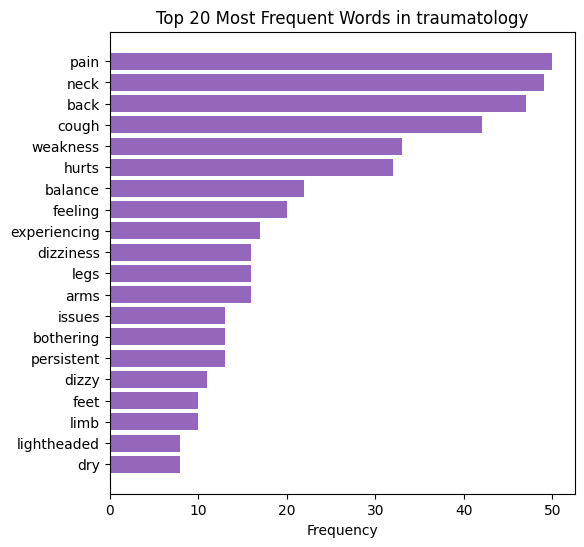

In [ ]:
def contador_graficador (especialidades_csv, colores):
  from collections import Counter
  from matplotlib import pyplot as plt
  colores = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
  csv_color = dict(zip(especialidades, colores))

  for esp in especialidades_csv:
    # Contamos las palabras en nuestro texto ya procesado
    all_words = ' '.join(esp['symptoms_tokenized']).split()
    word_counts = Counter(all_words)
    word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
    word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)

    #graficamos
    top_words = word_counts_df.head(20)

    plt.figure(figsize=(6, 6))
    plt.barh(top_words['Word'], top_words['Frequency'], color=csv_color[esp.clasificacion[0]])
    plt.gca().invert_yaxis()
    plt.xlabel('Frequency')
    plt.title(f'Top 20 Most Frequent Words in {esp.clasificacion[0]}')

contador_graficador(especialidades_csv,colores)

Podemos ver en cada especialidad cuales son las 20 palabras más frecuentes. <br>
Se ven palabras que no parecen ser especificas de clase en niveles muy elevados (como por ejemplo "also", "feeling", "really" en posiciones elevadas de Cronic Disease; "also", "lot", "really" tambien en Dermatology, y asi en las demas categorias). <br>

Modificaré el codigo para ver si puedo quitar esas palabras...

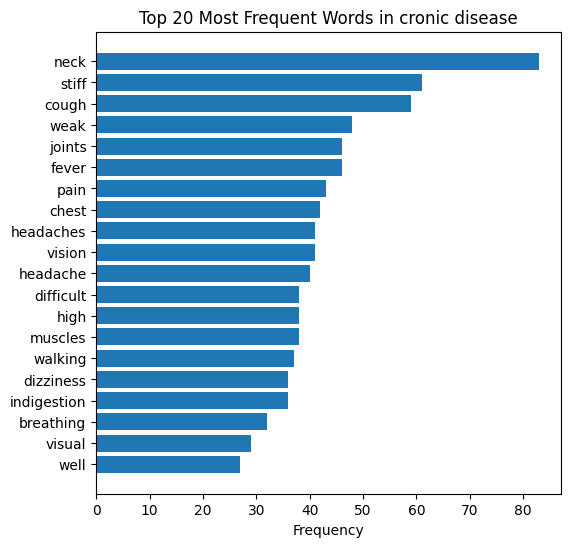

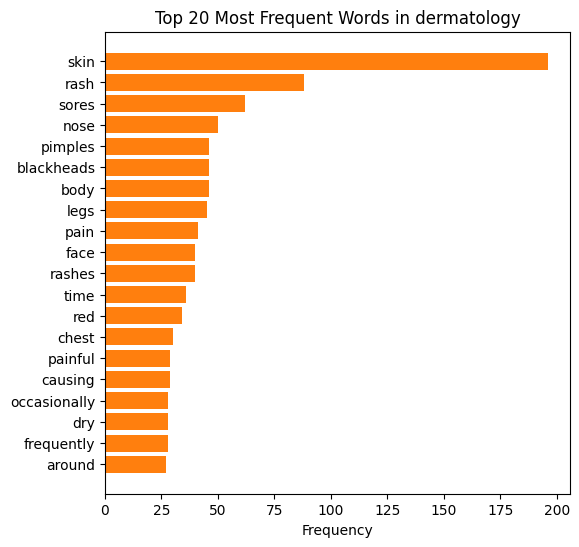

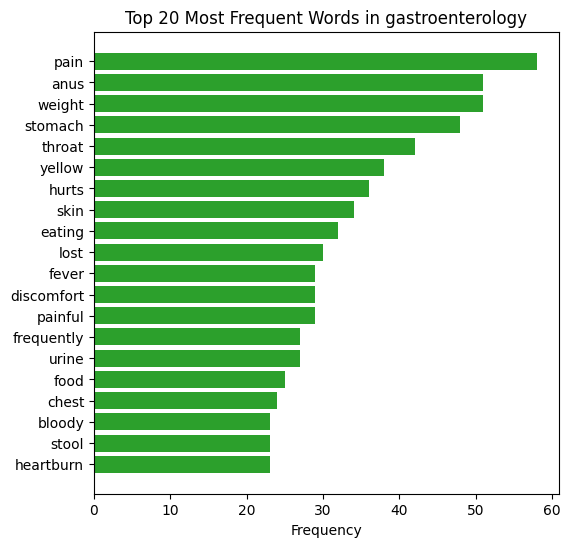

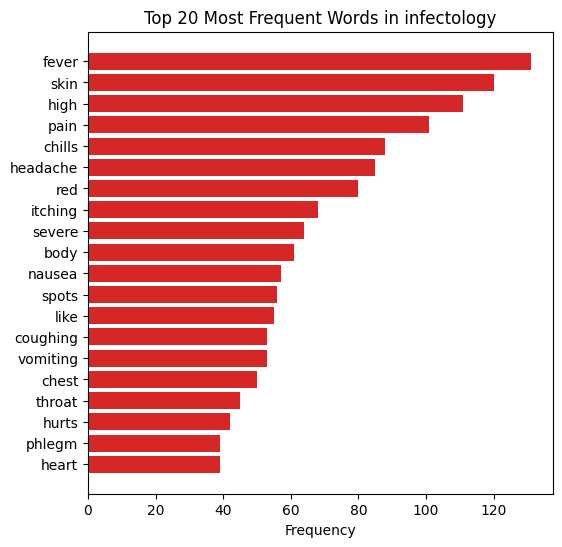

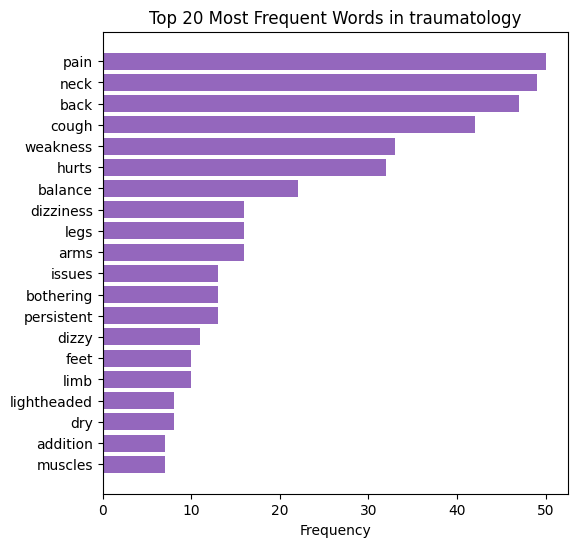

In [ ]:
def contador_graficador (especialidades_csv, colores):
  from collections import Counter
  from matplotlib import pyplot as plt
  colores = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
  csv_color = dict(zip(especialidades, colores))

  for esp in especialidades_csv:
    # Contamos las palabras en nuestro texto ya procesado
    all_words = ' '.join(esp['symptoms_tokenized']).split()
    word_counts = Counter(all_words)
    word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
    word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)
    stop_words_custom = {'feeling', 'also', 'really', 'lot', 'experiencing', 'get', 'feel', 'go', 'ca', 'quite'}
    filtered_word_counts_df = word_counts_df[~word_counts_df['Word'].isin(stop_words_custom)]
    #graficamos
    top_words = filtered_word_counts_df.head(20)

    plt.figure(figsize=(6, 6))
    plt.barh(top_words['Word'], top_words['Frequency'], color=csv_color[esp.clasificacion[0]])
    plt.gca().invert_yaxis()
    plt.xlabel('Frequency')
    plt.title(f'Top 20 Most Frequent Words in {esp.clasificacion[0]}')

contador_graficador(especialidades_csv,colores)

### Visualizacion WorldCloud

Visualización de nube de palabras mas frecuentes en el corpus, quitando las stopwords y las palabras customizadas. Lo encuadro en una mascara con fomra de cruz medica.

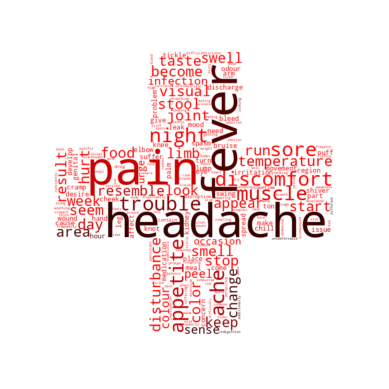

In [ ]:
from wordcloud import WordCloud, ImageColorGenerator
import numpy as np
import matplotlib.pyplot as plt

all_words = ' '.join(df['symptoms_tokenized']).split()
word_counts = Counter(all_words)
word_counts_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
word_counts_df = word_counts_df.sort_values(by='Frequency', ascending=False)
stop_words_custom = {'feeling', 'time', 'also', 'really', 'lot', 'experiencing', 'get', 'feel', 'go', 'ca', 'quite'}
filtered_word_counts_df = word_counts_df[~word_counts_df['Word'].isin(stop_words_custom)]
text=' '.join(filtered_word_counts_df['Word'])

# lo vamos a poner en una mascara con forma de cruz medica

url="https://github.com/LuisaBeccar/proyecto_nlp/blob/main/cruz.png?raw=true" # click derecho sobre imagen, copiar ruta de imagen
import requests
from io import BytesIO
from PIL import Image

page = requests.get(url)
my_mask = Image.open(BytesIO(page.content))

cross_color = np.array(my_mask)
cross_mask = cross_color.copy()
cross_mask[cross_mask.sum(axis=2) == 0] = 255
cross = WordCloud(margin=0, mask = cross_mask, background_color="white").generate(text)

image_colors = ImageColorGenerator(cross_color)
cross.recolor(color_func = image_colors)

plt.imshow(cross, interpolation='bilinear')
plt.axis('off')
plt.show()
cross.to_file("./cross.png")

In [ ]:
%%capture
#para usar mas adelante la lista de palabras
fifty_words = filtered_word_counts_df.sort_values(by='Frequency', ascending=False)
fifty_words = fifty_words['Word'].head(50)
fifty_words = ' '.join(fifty_words)
fifty_words.split(" ")

### Preprocesamineto 2

Del dataset df avanzo con el analisis de texto

In [ ]:
#vulevo a cargarlo por si acaso
df = open("df_preprocesado.csv")
df = pd.read_csv(df)
df.drop(columns="Unnamed: 0", inplace=True)
df.head(2)

,symptoms,clasificacion,clasificacion_encoded,symptoms_tokenized
0,I have been experiencing a skin rash on my arm...,dermatology,1,experiencing skin rash arms legs torso past we...
1,"My skin has been peeling, especially on my kne...",dermatology,1,skin peeling especially knees elbows scalp pee...


In [ ]:
# separo las descripciones y las etiquetas
X = df.symptoms
y = df.clasificacion

In [ ]:
# Train-Test sets. No tocar el test hasta el final.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)# con stratify espero me tome los conjuntos de datos para corregir el disbalance de clases

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((922,), (231,), (922,), (231,))

Para probar distintas practicas de procesamiento de texto: stop-words, bigramas, trigramas, lematizer, creo 3 vectorizadores distintos en los que iré utilizaré distintos métodos: <br>

  - Eliminacion de stopwords con _stop_words="english"_ <br>

  - Ngramas de distintos rangos:<br>
      - _ngram_range=(1,2)_<br>
      - _ngram_range=(1,3)_<br>

  - Lematizacion con _def lematizer_words_<br>

  - Preprocesador con los siguientes parametros para sacar caracteres no deseados y poner todo en minusculas:<br>
      - _df = df.lower()_<br>
      - _df = re.sub(r'\d+', '', df)_<br>
      


En la siguiente tabla se puede visualizar los parametros que utilizre en cada Vectorizador

In [ ]:
# tabla con los parametros de cada vectorizador

V1 = ["Vectorizer1", "English", "1,2","Lower Case + Sin Caracr Esp"]
V2 = ["Vectorizer2", "English", "1,3","Lower Case + Sin Caracr Esp"]
V3 = ["Vectorizer3", "English", "1,2", "Lower Case + Sin Caracr Esp + Lemmatizer"]

tablaV = pd.DataFrame([V1,V2,V3], columns=["Vectorizador","Stopwords", "Ngramas", "Preprocesamiento"])
display(tablaV)

,Vectorizador,Stopwords,Ngramas,Preprocesamiento
0,Vectorizer1,English,"1,2",Lower Case + Sin Caracr Esp
1,Vectorizer2,English,"1,3",Lower Case + Sin Caracr Esp
2,Vectorizer3,English,"1,2",Lower Case + Sin Caracr Esp + Lemmatizer


In [ ]:
# defino este preprocesador para los dos primeros vectorizadores (el tercero lo escribo distino, ver luego)
palabras_quitar = {'feeling', 'time', 'also', 'really', 'lot', 'experiencing', 'get', 'feel', 'go', 'ca', 'quite'}

import re

def preprocess_text_1y2(doc):
    doc = doc.lower()
    doc = re.sub(r'\d+', '', doc)
    # sacar cad apalabra de palabras_quitar y reemplazar por espacio
    for word in palabras_quitar:
        doc = re.sub(r'\b{}\b'.format(word), '', doc)
    return doc


lemmatizer = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

def preprocess_text_3_lemma(doc):  # en este caso meto los lower y quitador de caract no deseados en el lematizer asi queda un solo preprocesador
    doc = doc.lower()
    doc = re.sub(r'\d+', '', doc)
    for word in palabras_quitar:
        doc = re.sub(r'\b{}\b'.format(word), '', doc)
    return " ".join(lemmatizer.lemmatize(w) for w in analyzer(doc))# Join the lemmatized words back into a string


Instancio y luego utilizo cada vectorizador en fit_transform para el set de entrenemiento X_train y en transfomr el set de testeo X_test

In [ ]:
# Fitear y transsformar el train dataset en 3 tipos de vectorizadores


# Vectorizer1
count_vectorizer1 = CountVectorizer(preprocessor=preprocess_text_1y2, ngram_range=(1,2), stop_words="english")
X_train_v1 = count_vectorizer1.fit_transform(X_train)
X_test_v1 = count_vectorizer1.transform(X_test)

# Vectorizer2
count_vectorizer2 = CountVectorizer(preprocessor=preprocess_text_1y2, ngram_range=(1,3), stop_words="english")
X_train_v2 = count_vectorizer2.fit_transform(X_train)
X_test_v2 = count_vectorizer2.transform(X_test)


# Vectorizer3
count_vectorizer3 = CountVectorizer(ngram_range=(1,2), stop_words="english", preprocessor=preprocess_text_3_lemma ) #
X_train_v3 = count_vectorizer3.fit_transform(X_train)
X_test_v3 = count_vectorizer3.transform(X_test)


# ------

vectorizadores = {"CV1": (count_vectorizer1, X_train_v1, X_test_v1),
                  "CV2": (count_vectorizer2, X_train_v2, X_test_v2),
                  "CV3": (count_vectorizer2, X_train_v3, X_test_v3)}


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'wa'] not in stop_words.
  warnings.warn(


En la siguiente tabla muestro las combinaciones de modelo y vectorizadores que se probarán, siendo primero los 3 vectorizadores con Logistic Regression y luego el vectorizador 3 en los otros modelos que faltan (RF, GB y SCV)

In [ ]:
# tabla procedimiento

modelitos = ["CV1", "CV2", "CV3"]
vec = {
    "LR": ["si", "si", "si"],
    "RF": ["-", "-", "si"],
    "GB": ["-", "-", "si"],
    "SVC": ["-", "-", "si"]
}

# Create a DataFrame
tabla = pd.DataFrame(vec, index=modelitos[:len(vec["LR"])])

# Display the table
display(tabla)


,LR,RF,GB,SVC
CV1,si,-,-,-
CV2,si,-,-,-
CV3,si,si,si,si


### Modelos de Machine learning basados ene bag of words

In [ ]:
# importo modelos
from sklearn.linear_model import LogisticRegression
# solo usare el LR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


# importo halving gridsearchsv para hiperparametros
from sklearn.experimental import enable_halving_search_cv; # noqa
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
# instancio el Stratified K fold que usare para cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
# instancio 4 modelos

LR_model = LogisticRegression()
RF_model = RandomForestClassifier()
GB_model = GradientBoostingClassifier()
SVC_model = SVC()


In [ ]:
# grillas de hiperparametros para cada modelo

# param grid log_reg
params_log_reg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'l1_ratio': [0.1, 0.5, 0.9]  # Add l1_ratio for elasticnet
}

# params grid rf
params_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# params grid svm
params_svm = {
    'C':[1,10], # (el codigo que habia encontrado usaba tambien 100, 1000, pero me tardaria mucho entonces los saque)
    'gamma':[1,0.1,0.001,0.0001],
    'kernel':['linear','rbf']
    }


# params grid gb
param_gb = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'subsample': [0.7, 0.8, 1.0]
     }


#### Logistic Regression


##### LR V1

In [ ]:
#log_reg V1
%%capture
search_log_reg1 = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg1.fit(X_train_v1, y_train) # aplico el metodo a mis datos

best_model_log_reg1 = search_log_reg1.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg1 = best_model_log_reg1.predict(X_test_v1) # para luego obtener las metricas de clasificacion:
accuracy_log_reg1 = accuracy_score(y_test, y_pred_log_reg1)


In [ ]:
#log_reg V1
print(f"Classification Report for Logistic Regression 1:\n", classification_report(y_test, y_pred_log_reg1))
print(f"Best Model Logistic Regression V1:", best_model_log_reg1)
search_log_reg1.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Logistic Regression 1:
                   precision    recall  f1-score   support

  cronic disease       0.92      0.98      0.95        49
     dermatology       0.98      0.93      0.96        59
gastroenterology       1.00      1.00      1.00        35
     infectology       0.96      0.97      0.97        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.97       231
       macro avg       0.97      0.96      0.96       231
    weighted avg       0.97      0.97      0.97       231

Best Model Logistic Regression V1: LogisticRegression(C=100, l1_ratio=0.9, solver='saga')


{'solver': 'saga', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': 0.9, 'C': 100}

##### LR V2

In [ ]:
#log_reg V2
%%capture
search_log_reg2 = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg2.fit(X_train_v2, y_train) # aplico el metodo a mis datos

best_model_log_reg2 = search_log_reg2.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg2 = best_model_log_reg2.predict(X_test_v2) # para luego obtener las metricas de clasificacion:
accuracy_log_reg2 = accuracy_score(y_test, y_pred_log_reg2)


In [ ]:
#log_reg V2
print(f"Classification Report for Logistic Regression 2 :\n", classification_report(y_test, y_pred_log_reg2))
print(f"Best Model Logistic Regression V2:", best_model_log_reg2)
search_log_reg2.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Logistic Regression 2 :
                   precision    recall  f1-score   support

  cronic disease       0.92      0.98      0.95        49
     dermatology       0.98      0.95      0.97        59
gastroenterology       1.00      1.00      1.00        35
     infectology       0.99      0.99      0.99        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.97       231
       macro avg       0.98      0.96      0.97       231
    weighted avg       0.97      0.97      0.97       231

Best Model Logistic Regression V2: LogisticRegression(C=100, l1_ratio=0.9, max_iter=500, solver='liblinear')


{'solver': 'liblinear',
 'penalty': 'l2',
 'max_iter': 500,
 'l1_ratio': 0.9,
 'C': 100}

##### LR V3

In [ ]:
#log_reg V3
%%capture
search_log_reg3 = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg3.fit(X_train_v3, y_train) # aplico el metodo a mis datos

best_model_log_reg3 = search_log_reg3.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg3 = best_model_log_reg3.predict(X_test_v3) # para luego obtener las metricas de clasificacion:
accuracy_log_reg3 = accuracy_score(y_test, y_pred_log_reg3)


In [ ]:
#log_reg V3
print(f"Classification Report for Logistic Regression 3:\n", classification_report(y_test, y_pred_log_reg3))
print(f"Best Model Logistic Regression V3:", best_model_log_reg3)
search_log_reg3.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Logistic Regression 3:
                   precision    recall  f1-score   support

  cronic disease       0.92      1.00      0.96        49
     dermatology       1.00      0.92      0.96        59
gastroenterology       1.00      1.00      1.00        35
     infectology       0.96      0.99      0.97        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.97       231
       macro avg       0.98      0.96      0.97       231
    weighted avg       0.97      0.97      0.97       231

Best Model Logistic Regression V3: LogisticRegression(C=0.1, l1_ratio=0.5, max_iter=500, penalty=None,
                   solver='saga')


{'solver': 'saga', 'penalty': None, 'max_iter': 500, 'l1_ratio': 0.5, 'C': 0.1}

Accuracy scores de los 3 vectorizadores con logistic regression

In [ ]:
# ver las accuracys de los 3 vectorizadores en Logistic Regression
accuracysVect = [accuracy_log_reg1, accuracy_log_reg2, accuracy_log_reg3]
accuracies = pd.DataFrame({"Vectorizador": ["V1", "V2", "V3"], "Accuracy": accuracysVect})
accuracies

,Vectorizador,Accuracy
0,V1,0.965368
1,V2,0.974026
2,V3,0.969697


Los tres son bastantes parecidos, nos quedaremos con el tercero que tiene lematizacion y es de los mejores

#### Otros modelos

##### RF V3

In [ ]:
# random forest v3
%%capture
search_rf = HalvingRandomSearchCV(RF_model, params_rf, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_rf.fit(X_train_v3, y_train) # aplico el metodo a mis datos

best_model_rf = search_rf.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_rf = best_model_rf.predict(X_test_v3) # para luego obtener las metricas de clasificacion
accuracy_rf = accuracy_score(y_test, y_pred_rf)

In [ ]:
# random forest v3
print(f"Classification Report for Random Forest :\n", classification_report(y_test, y_pred_rf))
print(f"Best Model Random Forest:", best_model_rf)
search_rf.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Random Forest :
                   precision    recall  f1-score   support

  cronic disease       0.98      1.00      0.99        49
     dermatology       1.00      0.86      0.93        59
gastroenterology       1.00      1.00      1.00        35
     infectology       0.91      1.00      0.95        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.96       231
       macro avg       0.98      0.95      0.96       231
    weighted avg       0.96      0.96      0.96       231

Best Model Random Forest: RandomForestClassifier(max_features='log2', n_estimators=300)


{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None}

##### SVM V3

In [ ]:
# svm v3
%%capture
search_svc = HalvingRandomSearchCV(SVC_model, params_svm, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_svc.fit(X_train_v3, y_train) # aplico el metodo a mis datos

best_model_svc = search_svc.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_svc = best_model_svc.predict(X_test_v3) # para luego obtener las metricas de clasificacion
accuracy_svc = accuracy_score(y_test, y_pred_svc)

In [ ]:
# svm v3
print(f"Classification Report for Support Vector Machine Classifier :\n", classification_report(y_test, y_pred_svc))
print(f"Best Model Support Vector Machine Classifier:", best_model_svc)
search_svc.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Support Vector Machine Classifier :
                   precision    recall  f1-score   support

  cronic disease       0.92      1.00      0.96        49
     dermatology       1.00      0.93      0.96        59
gastroenterology       1.00      1.00      1.00        35
     infectology       0.97      0.99      0.98        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.97       231
       macro avg       0.98      0.96      0.97       231
    weighted avg       0.98      0.97      0.97       231

Best Model Support Vector Machine Classifier: SVC(C=10, gamma=0.0001, kernel='linear')


{'kernel': 'linear', 'gamma': 0.0001, 'C': 10}

##### GB V3

In [ ]:
# gb v3
# tarda unos 15-20 minutos
%%capture
search_gb = HalvingRandomSearchCV(GB_model, param_gb, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_gb.fit(X_train_v3, y_train) # aplico el metodo a mis datos

best_model_gb = search_gb.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_gb = best_model_gb.predict(X_test_v3) # para luego obtener las metricas de clasificacion
accuracy_gb = accuracy_score(y_test, y_pred_gb)

In [ ]:
# gb v3
print(f"Classification Report for Gradient Boosting :\n", classification_report(y_test, y_pred_gb))
print(f"Best Model Gradient Boosting:", best_model_gb)
search_gb.best_params_ # para chequear que sean como los que indica el best_model

Classification Report for Gradient Boosting :
                   precision    recall  f1-score   support

  cronic disease       0.96      0.96      0.96        49
     dermatology       0.96      0.92      0.94        59
gastroenterology       0.94      0.97      0.96        35
     infectology       0.94      0.97      0.96        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.95       231
       macro avg       0.96      0.94      0.95       231
    weighted avg       0.95      0.95      0.95       231

Best Model Gradient Boosting: GradientBoostingClassifier(max_depth=7, min_samples_leaf=2, n_estimators=200,
                           subsample=0.7)


{'subsample': 0.7,
 'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 7,
 'learning_rate': 0.1}

Accuracy todos los modelos con CV3

In [ ]:
modelos = ["RL", "RF", "SVM", "GB"]
accuracy_hrscv = [accuracy_log_reg3, accuracy_rf, accuracy_svc, accuracy_gb]

resultados_hrscv_skf = pd.DataFrame({'Modelo': modelos, 'Accuracy': accuracy_hrscv})
resultados_hrscv_skf.round(3)

,Modelo,Accuracy
0,RL,0.970
1,RF,0.961
2,SVM,0.974
3,GB,0.952


De todos los modelos con el vectorizador 3, los de mejor puntaje son el Logistic Regression y el SVC con accuracy score de 0.974 <br>

Quedaria por probar los demas modelos para los otros vectorizadores (V2, V3), pero como se tarda mucho, me quedaré con este resultado.
<br>
Se puede ver cómo con distintos vectorizadores y distintos modelos se puede obtener distintas métricas, algunos se ajustan mejor que otros.
<br>


#### New inputs

Aqui probare el mejor modelo de LR con nuevos inputs

In [ ]:
the_model = best_model_log_reg3
vectorizer = count_vectorizer3

In [ ]:
inventados = ["neck pain", "running nose and sore throat", "a mosquito bite", "skin rash", "high fever and dizziness"]

In [ ]:
for i in inventados:
  nueva_prediccion = vectorizer.transform([i])
  print(i)
  print(the_model.predict(nueva_prediccion))

neck pain
['traumatology']
running nose and sore throat
['dermatology']
a mosquito bite
['dermatology']
skin rash
['dermatology']
high fever and dizziness
['cronic disease']


Probando con diferentes sintomas, se evidencian errores de clasificacion, a pesar de tener un buen accuracy score.

#### Coeficintes de correlacion LR V3:

Para cada categoria diagnositca, ver los ngramas con mayor correlacion positva y negativa.

In [ ]:
# tomar los coeficientes del modelo best log reg 3
coefficients = the_model.coef_

# tomar los bigramas del count vectorizer 3 sacando stopwords
ngram_features = vectorizer.get_feature_names_out()

# dataframe que guarde los coeficientes para cada bigrama
results = pd.DataFrame(coefficients, columns = ngram_features)

# agregar el nombre de categoria como idicaes
results.index = best_model_log_reg1.classes_

# para cada categoria dame los bigramas con los 10 coeficientes mejores y peores
for category in results.index:
    category_results = results.loc[category].reset_index()
    category_results.columns = ['ngram', 'coefficient']

    # los mejores 10
    top_ngrams = category_results.nlargest(10, 'coefficient')[['ngram', 'coefficient']]
    top_ngrams.columns = ['ngram', 'coefficient_top']

    # los peores 10
    bottom_ngrams = category_results.nsmallest(10, 'coefficient')[['ngram', 'coefficient']]
    bottom_ngrams.columns = ['ngram', 'coefficient_bottom']

    # prints
    display(f'Category: {category}')
    display('Top 10 Ngrams:', top_ngrams)
    display('Bottom 10 Ngrams:', bottom_ngrams)
    print('---')

display("Tabla general de coeficientes", results)

'Category: cronic disease'

'Top 10 Ngrams:'

,ngram,coefficient_top
6974,vision,2.428087
5933,stiff,1.472783
1727,dizziness,1.423082
947,chest pain,1.406220
4520,pain dizziness,1.405118
3123,hungry,1.291148
1073,concentrate,1.141618
2942,headache,1.086088
2949,headache chest,1.080102
4640,palpitation,1.079258


'Bottom 10 Ngrams:'

,ngram,coefficient_bottom
3131,hurt,-1.106816
4492,pain,-1.020092
1642,discomfort,-0.934687
3593,leg,-0.896793
953,chill,-0.872901
339,arm,-0.864053
4286,nose,-0.827245
6266,temperature,-0.793430
5425,severe,-0.731164
2133,eye,-0.705060


---


'Category: dermatology'

'Top 10 Ngrams:'

,ngram,coefficient_top
4286,nose,1.996431
5780,sore,1.848736
3593,leg,1.846121
1315,cramp,1.800603
4987,rash,1.650306
844,calf,1.617070
2169,face,1.400349
3476,joint,1.231261
4111,nail,1.211568
1827,dry,1.197473


'Bottom 10 Ngrams:'

,ngram,coefficient_bottom
4181,neck,-1.450978
5840,spot,-0.854642
796,bump,-0.849248
6817,ve,-0.844224
5957,stomach,-0.835723
6974,vision,-0.775540
7085,weak,-0.770179
3414,itching,-0.745286
424,balance,-0.682553
1951,especially,-0.674537


---


'Category: gastroenterology'

'Top 10 Ngrams:'

,ngram,coefficient_top
5979,stool,1.720353
244,anus,1.695813
7148,weight,1.593281
1868,eating,1.527064
7295,yellow,1.511903
700,bowel,1.336889
5957,stomach,1.301990
2454,food,1.290963
3814,lost weight,1.130822
3028,heartburn,1.062565


'Bottom 10 Ngrams:'

,ngram,coefficient_bottom
2942,headache,-1.346557
4286,nose,-1.023584
4071,muscle,-0.889840
1827,dry,-0.800378
636,body,-0.792484
4987,rash,-0.760526
1216,cough,-0.742185
3593,leg,-0.727994
6740,urinate,-0.698664
5723,smell,-0.637625


---


'Category: infectology'

'Top 10 Ngrams:'

,ngram,coefficient_top
953,chill,2.070225
4670,pee,1.702526
3806,lost appetite,1.699895
5108,red,1.523287
5840,spot,1.489747
7007,vomiting,1.443039
3942,mild,1.414287
320,area,1.378576
5723,smell,1.365143
42,accompanied,1.323141


'Bottom 10 Ngrams:'

,ngram,coefficient_bottom
7295,yellow,-1.347366
1827,dry,-1.163123
7148,weight,-1.160946
947,chest pain,-1.146347
1754,dizzy,-1.143958
6249,taste,-1.130925
5780,sore,-0.973788
4009,mouth,-0.958172
3814,lost weight,-0.795915
3476,joint,-0.783256


---


'Category: traumatology'

'Top 10 Ngrams:'

,ngram,coefficient_top
4181,neck,1.533251
4196,neck hurt,1.312936
7114,weakness,1.218860
1216,cough,0.994486
424,balance,0.815222
3715,limb,0.736907
684,bothering,0.617633
4202,neck pain,0.587919
347,arm leg,0.575559
6879,ve lightheaded,0.562928


'Bottom 10 Ngrams:'

,ngram,coefficient_bottom
937,chest,-1.058885
2709,ha,-1.016072
5595,skin,-0.860409
2278,fever,-0.833166
2942,headache,-0.829567
6364,throat,-0.791952
2528,frequently,-0.675886
4987,rash,-0.653136
3476,joint,-0.591946
1565,difficult,-0.565704


---


'Tabla general de coeficientes'

,abdomen,abdomen ache,abdomen bad,abdomen bothering,abdomen buring,abdomen day,abdomen feverish,abdomen frequently,abdomen ha,abdomen hour,...,yellow skin,yellow urine,yellow ve,yellowish,yesterday,yesterday face,yesterday noticed,yesterday severe,zone,zone head
cronic disease,-0.257060,-0.026507,-0.069623,-0.006149,-0.021561,-0.027687,-0.004218,-0.021687,-0.016071,-0.010827,...,-0.007032,-0.016243,-0.014782,-0.005283,-0.004662,-0.001040,-0.000871,-0.002751,0.139291,0.139291
dermatology,-0.248489,-0.005767,-0.008663,-0.009965,-0.029298,-0.089551,-0.005626,-0.068023,-0.006723,-0.013409,...,-0.008752,-0.036757,-0.002782,-0.008664,-0.054877,0.003726,0.002665,-0.061267,-0.057335,-0.057335
gastroenterology,0.803808,-0.007109,0.195537,0.029624,-0.030381,0.233485,-0.005834,0.115043,0.029440,0.036459,...,0.098449,0.359045,0.093285,-0.015703,-0.001585,-0.000565,-0.000509,-0.000510,-0.015197,-0.015197
infectology,-0.176631,0.040674,-0.087212,-0.008758,0.105913,-0.101088,0.019610,-0.016726,-0.003933,-0.005543,...,-0.079683,-0.297415,-0.074896,0.033411,0.062293,-0.002011,-0.001195,0.065499,-0.057577,-0.057577
traumatology,-0.121628,-0.001291,-0.030038,-0.004753,-0.024673,-0.015158,-0.003932,-0.008607,-0.002714,-0.006681,...,-0.002983,-0.008630,-0.000824,-0.003762,-0.001170,-0.000110,-0.000089,-0.000971,-0.009183,-0.009183


Estas tablas de coeficientes viene a complementar los gaficos de barras de word count por categorias hecho mas arriba.

Mirando en detalle las tablas de coeficientes, vemos como hay algunos ngramas que con conocimiento de experto están con pesos superiores a los que uno pensaría para el tipo de enfermedades, por ejemplo: "weakness# y #cough" como el tercro y cuarto en importancia para la categoria "traumatology".<br>
 Asi se entiende que el modelo cometa errores.

#### TF-IDF

Ahora probaremos el modelo y con el TfidfVectorizer, que buscara las palabras con mayo relevancia relativa en el corpus

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

# Initialize the TF-IDF Vectorizer   + ngrama + min_df (ignorar si no aparece mas de 5 veces) + preprocessor que use en el V3 con lematizacion
vectorizerTFIDF = TfidfVectorizer(stop_words='english', preprocessor=preprocess_text_3_lemma, ngram_range=(1,2), min_df=5)

# Transform the text data
X_train_tfidf = vectorizerTFIDF.fit_transform(X_train)
X_test_tfidf = vectorizerTFIDF.transform(X_test)



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'wa'] not in stop_words.
  warnings.warn(


In [ ]:
# log reg con vectorizador tfidf
%%capture
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  HalvingGridSearchCV, HalvingRandomSearchCV


search_log_reg_tfidf = HalvingRandomSearchCV(LR_model, params_log_reg, cv=skf, factor=2, scoring='accuracy', random_state=42, n_jobs=-1) # instancio el buscador de hiperparametros para mi modelo (en este caso el regresion logistica) con la grilla que hice para él y par aque el score que optimice sea el accuracy, con el cv=skf definido arroba en Stratified K Fold Cross Validation
search_log_reg_tfidf.fit(X_train_tfidf, y_train) # aplico el metodo a mis datos

best_model_log_reg_tfidf = search_log_reg_tfidf.best_estimator_ # obtener el modelo con sus mejores hiperparametos para el scoring elegido

y_pred_log_reg_tfidf= best_model_log_reg_tfidf.predict(X_test_tfidf) # para luego obtener las metricas de clasificacion:
accuracy_log_reg_tfdif = accuracy_score(y_test, y_pred_log_reg_tfidf)


In [ ]:
print(f"Classification Report for LR TFIDF:\n", classification_report(y_test, y_pred_log_reg_tfidf))
print(f"Best Model LR TFIDF:", best_model_log_reg_tfidf)
print(f"Accuracy Score for LR TFIDF:", accuracy_log_reg_tfdif)

Classification Report for LR TFIDF:
                   precision    recall  f1-score   support

  cronic disease       0.94      1.00      0.97        49
     dermatology       1.00      0.92      0.96        59
gastroenterology       1.00      1.00      1.00        35
     infectology       0.96      1.00      0.98        78
    traumatology       1.00      0.90      0.95        10

        accuracy                           0.97       231
       macro avg       0.98      0.96      0.97       231
    weighted avg       0.98      0.97      0.97       231

Best Model LR TFIDF: LogisticRegression(C=0.1, l1_ratio=0.5, max_iter=500, penalty=None,
                   solver='saga')
Accuracy Score for LR TFIDF: 0.974025974025974


Da un mismo accuracy score que los intentados antes. <br>
Igualmente, lo probaremos con los nuevos inputs definidos previamente:
A probarlo con nuevos inputs...

In [ ]:
for i in inventados:
  nueva_prediccion = vectorizerTFIDF.transform([i])
  print(i)
  print(best_model_log_reg_tfidf.predict(nueva_prediccion))

neck pain
['traumatology']
running nose and sore throat
['dermatology']
a mosquito bite
['dermatology']
skin rash
['dermatology']
high fever and dizziness
['cronic disease']


Bueno, incluso con el TF IDF no funciona muy bien y comete errores ante nuevos inputs. Se observa que cambió la prediccion de uno de los new inputs, el de " amosquito bite" que el rf predecia como "dermatology", el tfidf predice como "cronic disease".



**Conclusiones:** <br>

Si bien los modelos tienen buenas metricas de accuracy, fallan al introducirle nuevos inputs.<br>
Por qué sucede esto?
<br>
Probablemente por la reducida cantidad de datos de training, sumado a quizas una mala primera clasificacion de enfermedades.
<br>

Lineas futuras podrian incluir adjuntar más registros a la base de datos de entrenamiento, revisando que estén bien etiquetados.

#### Extra


Intento de automatizar la busqueda a los 3 vectorizadores para los 4 modelos, todos con SKF y Halving Random Search de hiperparametros.

al no completarse en 6 horas, aborté mision y silencio el codigo para no ser corrido.


In [ ]:
"""
import pandas as pd
from sklearn.experimental import enable_halving_search_cv  # Enable experimental HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

# con los 4 modelos, sus hiperparametros y los 3 vectorizadores instanciados...

models = {
    "LogisticRegression": (LogisticRegression(), params_log_reg),
    "RandomForest": (RandomForestClassifier(), params_rf),
    "GradientBoosting": (GradientBoostingClassifier(), param_gb),
    "SVC": (SVC(), params_svm)
}

vectorizadores = {"CV1": (count_vectorizer1, X_train_v1, X_test_v1),
                  "CV2": (count_vectorizer2, X_train_v2, X_test_v2),
                  "CV3": (count_vectorizer2, X_train_v3, X_test_v3)}


def train_evaluate_models(vectorizers, models, X_train, X_test, y_train, y_test):
    results = []
    reports = {}

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for vec_name, vectorizer_tuple in vectorizers.items():  # loop de para cada vectorizador:  transformar el X_train y X_test, luego indentado, probar cada modelo
        print(f"\nVectorizador: {vec_name}")
        vectorizer = vectorizer_tuple[0]

        X_train_vec = vectorizer.fit_transform(X_train) # Fit y transform el train
        X_test_vec = vectorizer.transform(X_test)       # solo transform el test

        for model_name, (model, param_grid) in models.items():  # para cada vectorizador probar cada modelo
            print(f"Entrenando modelo: {model_name} con {vec_name}")

            grid_search = HalvingGridSearchCV(model, param_grid, scoring='accuracy', cv=skf, verbose=1, n_jobs=-1)
            grid_search.fit(X_train_vec, y_train)

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test_vec)
            acc = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)

            results.append({
                "Vectorizer": vec_name,
                "Model": model_name,
                "Best Params": grid_search.best_params_,
                "Accuracy": acc
            })
            reports[(vec_name, model_name)] = classification_report(y_test, y_pred)

    results_df = pd.DataFrame(results)
    return results_df, reports

# usar la funcion definida y que me de los resultados y reportes
results_df, reports = train_evaluate_models(vectorizadores, models, X_train, X_test, y_train, y_test)
print("\nResultados:")
print(results_df)

# Guardar informes de clasificación
for (vec_name, model_name), report in reports.items():
    print(f"\nInforme para {model_name} con {vec_name}:\n")
    print(report)
"""

'\nimport pandas as pd\nfrom sklearn.experimental import enable_halving_search_cv  # Enable experimental HalvingGridSearchCV\nfrom sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold\nfrom sklearn.metrics import classification_report, accuracy_score\n\n# con los 4 modelos, sus hiperparametros y los 3 vectorizadores instanciados...\n\nmodels = {\n    "LogisticRegression": (LogisticRegression(), params_log_reg),\n    "RandomForest": (RandomForestClassifier(), params_rf),\n    "GradientBoosting": (GradientBoostingClassifier(), param_gb),\n    "SVC": (SVC(), params_svm)\n}\n\nvectorizadores = {"CV1": (count_vectorizer1, X_train_v1, X_test_v1),\n                  "CV2": (count_vectorizer2, X_train_v2, X_test_v2),\n                  "CV3": (count_vectorizer2, X_train_v3, X_test_v3)}\n\n\ndef train_evaluate_models(vectorizers, models, X_train, X_test, y_train, y_test):\n    results = []\n    reports = {}\n\n    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)\n

# Deep Learning

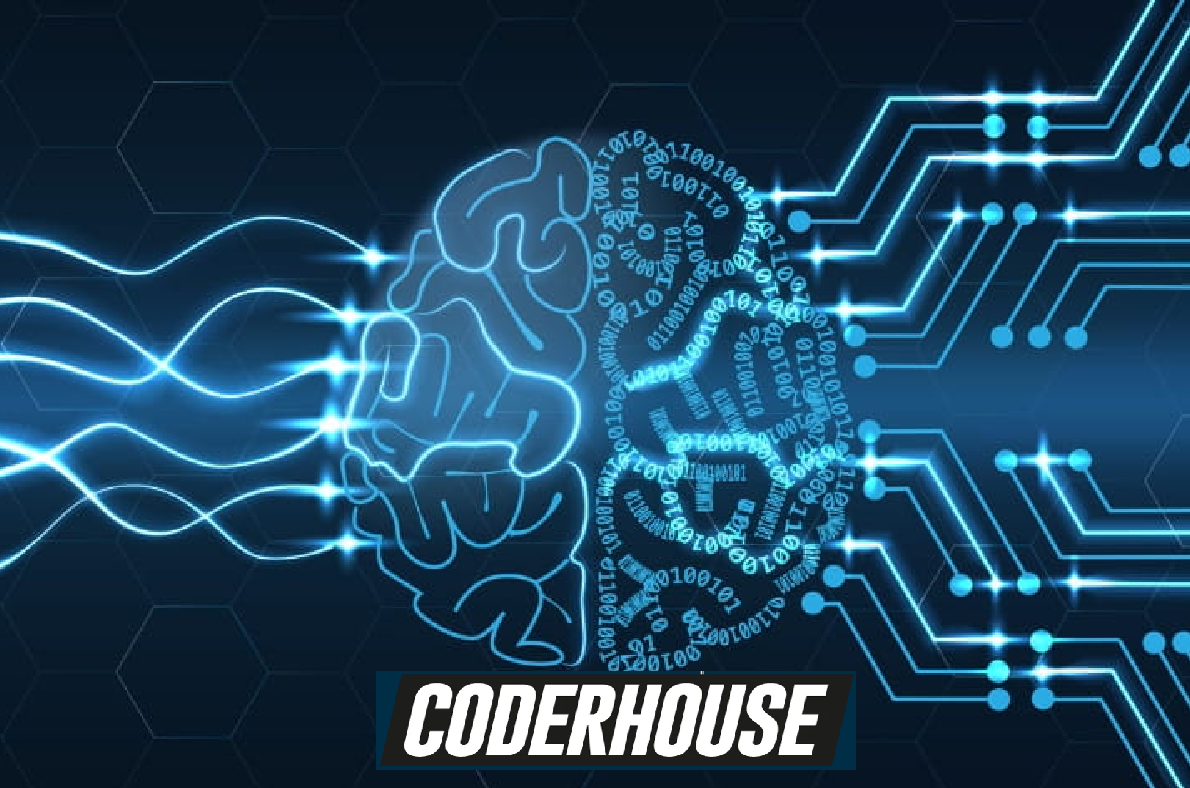

Siguiendo con el problema de clasificacion, pondre manos a la obra usando distintos algoritmos de redes neuronales para intentar resolver mi problema de clasificacion... <br>

Teniendo en cuenta que mi datast tiene un pequeño numero de muestras, los resultados de utilizar de deep learning probablemnte no sean buenos

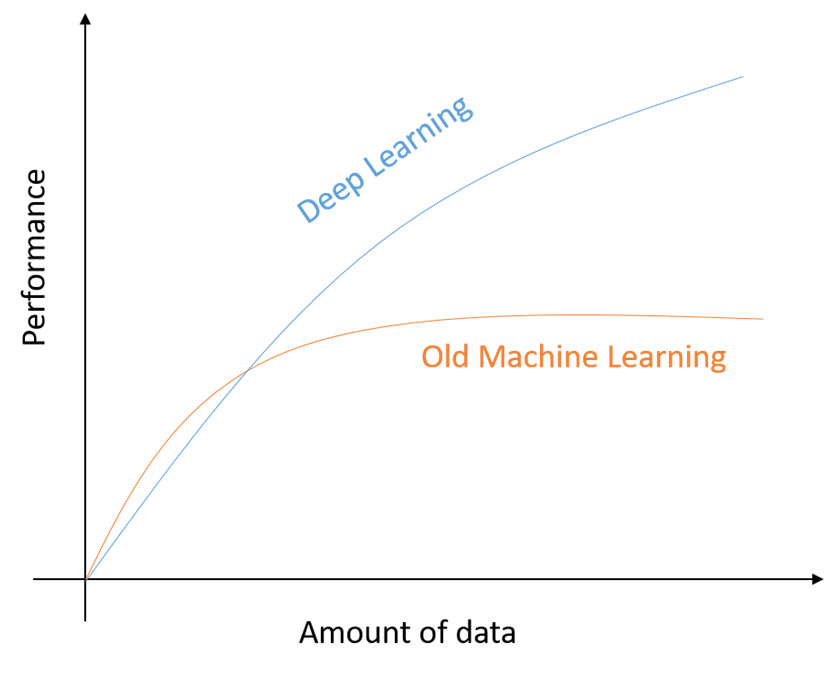



In [ ]:
#vulevo a cargarlo por si acaso
df = open("df_preprocesado.csv")
df = pd.read_csv(df)
df.drop(columns="Unnamed: 0", inplace=True)
df.head(2)

,symptoms,clasificacion,clasificacion_encoded,symptoms_tokenized
0,I have been experiencing a skin rash on my arm...,dermatology,1,experiencing skin rash arms legs torso past we...
1,"My skin has been peeling, especially on my kne...",dermatology,1,skin peeling especially knees elbows scalp pee...


## Tensor Flow Simple

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

x = df["symptoms_tokenized"]
y = df['clasificacion_encoded']

max_words = 20000 # maximo del corpus
max_length = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical

num_classes = len(label_encoder.classes_)
labels_tensor = to_categorical(y, num_classes=num_classes)

model0 = Sequential()  # fully connected
model0.add(Input(shape=(max_length, 1 )))
model0.add(Flatten())
model0.add(Dense(10, activation='relu')) # una capa oculta
model0.add(Dense(5, activation='softmax')) # salida, son 5 categorias asique ese 5
model0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
labels = to_categorical(y, num_classes=num_classes)

model0.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           5,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              55 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,065 (19.79 KB)

 Trainable params: 5,065 (19.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist0 = model0.fit(x, labels, validation_split=0.2, epochs=20)


Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.2007 - loss: 23.8023 - val_accuracy: 0.1861 - val_loss: 13.0860
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2530 - loss: 7.3158 - val_accuracy: 0.2771 - val_loss: 4.4947
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2834 - loss: 3.2943 - val_accuracy: 0.0130 - val_loss: 3.1979
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3940 - loss: 2.1747 - val_accuracy: 0.0087 - val_loss: 2.6019
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4047 - loss: 1.8649 - val_accuracy: 0.0000e+00 - val_loss: 2.2685
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4071 - loss: 1.9451 - val_accuracy: 0.0000e+00 - val_loss: 2.1275
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4215 - loss: 1.7621 - val_accuracy: 0.0043 - val_loss: 2.0313
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4252 - loss: 1.6558 - val_accuracy: 0.0000e

Visualizacion

[]

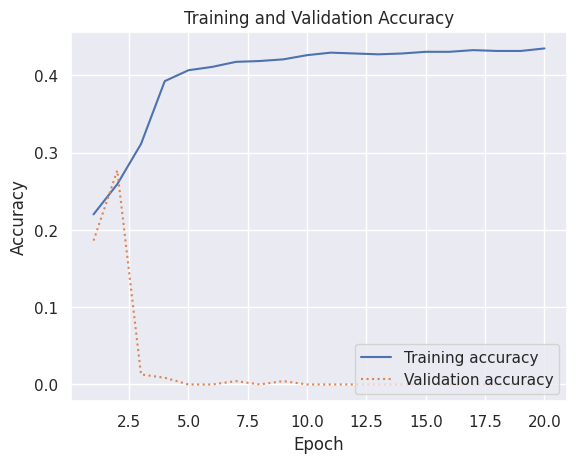

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist0.history['accuracy']
val = hist0.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()


Este modelo presenta un tipico grafico de overfitting, donde el accuracy aumenta y el validation score en cambio alcanza un máximo y luego comienza a disminuir después de unas pocas épocas. Es decir, el modelo ha aprendido a ajustarse demasiado a los datos de entrenamiento, lo que le permite obtener una mayor precisión en este conjunto, pero pierde capacidad de generalización en el conjunto de validación.
Ademas el accuracy alcanzado es muy bajo (0.4 aproximadamente).

Prediccion

In [ ]:
# Realizar predicción
test_texts = ["neck pain", "running nose and sore throat", "a mosquito bite", "skin rash", "high fever and dizziness"]

# Tokenizar y paddear el test text
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(test_sequences, maxlen=max_length)

# Expandir dimensiones para matchear el model input shape
test_data = np.expand_dims(test_data, axis=-1)

# Hacer predicciones para cada texto de `test_texts`
for i, text in enumerate(test_texts):
    # Predecir probabilidades
    test_predictions = model0.predict(test_data[i:i+1])
    predicted_class = np.argmax(test_predictions, axis=1)
    predicted_label = label_encoder.inverse_transform(predicted_class)

    print(f"Text: {text}\nPredicted Category: {predicted_label[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Text: neck pain
Predicted Category: infectology
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Text: running nose and sore throat
Predicted Category: cronic disease
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Text: a mosquito bite
Predicted Category: infectology
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Text: skin rash
Predicted Category: infectology
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Text: high fever and dizziness
Predicted Category: infectology


## Tensor Flow con Embedding

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

x = df["symptoms_tokenized"]
y = df['clasificacion_encoded']

max_words = 20000 # maximo del corpus
max_length = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input

model1 = Sequential()  # fully connected
model1.add(Input(shape=(max_length,1)))
model1.add(Embedding(max_words, 32))  # el EMBEDDING da dimension a cada palabra
model1.add(Flatten())
model1.add(Dense(10, activation='relu')) # una capa oculta
model1.add(Dense(5, activation='softmax')) # salida , son 5 categorias asique ese 5
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
labels = to_categorical(y, num_classes=num_classes)
model1.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 500, 1, 32)          │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │         160,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │              55 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 800,065 (3.05 MB)

 Trainable params: 800,065 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist1 = model1.fit(x, labels, validation_split=0.2, epochs=20)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.3842 - loss: 1.4637 - val_accuracy: 0.0000e+00 - val_loss: 2.0660
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4048 - loss: 1.4067 - val_accuracy: 0.0000e+00 - val_loss: 2.3583
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5025 - loss: 1.2197 - val_accuracy: 0.0173 - val_loss: 1.8322
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5953 - loss: 0.9625 - val_accuracy: 0.0173 - val_loss: 1.9336
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6842 - loss: 0.7763 - val_accuracy: 0.2208 - val_loss: 2.0418
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8217 - loss: 0.6192 - val_accuracy: 0.2424 - val_loss: 2.4321
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8520 - loss: 0.5155 - val_accuracy: 0.1861 - val_loss: 3.1261
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8976 - loss: 0.4097 - val_accuracy: 0.

Visualizacion

[]

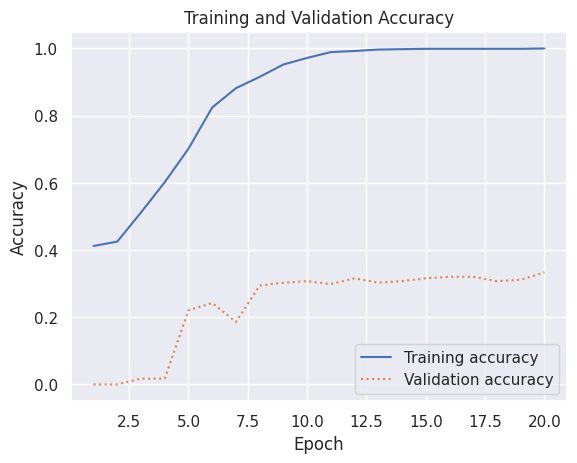

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist1.history['accuracy']
val = hist1.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Este modelo el accuracy va aumentando hacias 0.8 con el entrenamiento. El el validation score aumentan tambien, de manera constante y similar hasta alcanzar una meseta, indicando que el modelo ha aprendido pero la diferencia entre las predicciones y los datos reales fue aumentando un poco.

Prediccion

In [ ]:
# Realizar predicción
test_texts = ["neck pain", "running nose and sore throat", "a mosquito bite", "skin rash", "high fever and dizziness"]

# Tokenizar y paddear el test text
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(test_sequences, maxlen=max_length)

# Expandir dimensiones para matchear el model input shape
test_data = np.expand_dims(test_data, axis=-1)

# Hacer predicciones para cada texto de `test_texts`
for i, text in enumerate(test_texts):
    # Predecir probabilidades
    test_predictions = model1.predict(test_data[i:i+1])  # Predict for one text at a time
    predicted_class = np.argmax(test_predictions, axis=1)  # Get the index of the highest probability
    predicted_label = label_encoder.inverse_transform(predicted_class)  # Map index to category

    print(f"Text: {text}\nPredicted Category: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Text: neck pain
Predicted Category: dermatology
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Text: running nose and sore throat
Predicted Category: dermatology
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Text: a mosquito bite
Predicted Category: dermatology
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Text: skin rash
Predicted Category: dermatology
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Text: high fever and dizziness
Predicted Category: dermatology


## Tensor Flow con Embedding + Convolucion & Pooling

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

x = df["symptoms_tokenized"]
y = df['clasificacion_encoded']

max_words = 20000 # maximo del corpus
max_length = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input

model2 = Sequential()
model2.add(Input(shape=(max_length,)))
model2.add(Embedding(max_words, 32)) # embedding
model2.add(Conv1D(32, 7, activation='relu'))  # convolucional
model2.add(GlobalMaxPooling1D())  # pooling
model2.add(Dense(5, activation='softmax')) # la ultima fully connected, son 5 categorias asique ese 5
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
label = to_categorical(y, num_classes=num_classes)
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 500, 32)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 494, 32)             │           7,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 647,365 (2.47 MB)

 Trainable params: 647,365 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist2 = model2.fit(x, label, validation_split=0.2, epochs=20)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.3136 - loss: 1.5346 - val_accuracy: 0.0000e+00 - val_loss: 2.0724
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4447 - loss: 1.3100 - val_accuracy: 0.0000e+00 - val_loss: 1.8589
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5192 - loss: 1.1818 - val_accuracy: 0.0000e+00 - val_loss: 1.9171
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7580 - loss: 0.9171 - val_accuracy: 0.0000e+00 - val_loss: 2.1226
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8436 - loss: 0.5810 - val_accuracy: 0.0606 - val_loss: 2.1368
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9666 - loss: 0.3375 - val_accuracy: 0.0823 - val_loss: 2.4714
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9912 - loss: 0.1630 - val_accuracy: 0.1472 - val_loss: 2.5456
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9992 - loss: 0.0893 - val_accu

Visualizacion

[]

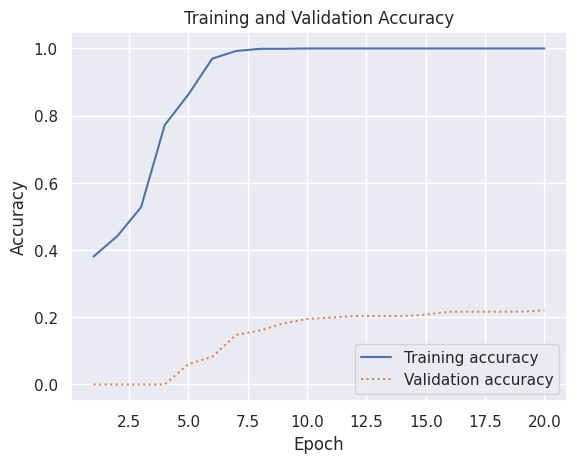

In [ ]:
acc = hist2.history['accuracy']
val = hist2.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()


Este modelo, muestra que el accuracy aumenta y llega a 1 y el validation score tambien aumentan de manera constante y similar, hasta alcanzar una meseta.
Como en el modelo anterior, podria indicar que el modelo ha aprendido pero la diferencia entre las predicciones y los datos reales aumentó, por lo que no dara buenos predicciones.

Prediccion

In [ ]:
# Realizar predicción
test_texts = ["neck pain", "running nose and sore throat", "a mosquito bite", "skin rash", "high fever and dizziness"]

# Tokenizar y paddear el test text
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(test_sequences, maxlen=max_length)

# Expandir dimensiones para matchear el model input shape
test_data = np.expand_dims(test_data, axis=-1)

# Hacer predicciones para cada texto de `test_texts`
for i, text in enumerate(test_texts):
    # Predecir probabilidades
    test_predictions = model2.predict(test_data[i:i+1])  # Predict for one text at a time
    predicted_class = np.argmax(test_predictions, axis=1)  # Get the index of the highest probability
    predicted_label = label_encoder.inverse_transform(predicted_class)  # Map index to category

    print(f"Text: {text}\nPredicted Category: {predicted_label[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Text: neck pain
Predicted Category: infectology
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Text: running nose and sore throat
Predicted Category: infectology
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Text: a mosquito bite
Predicted Category: infectology
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Text: skin rash
Predicted Category: infectology
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Text: high fever and dizziness
Predicted Category: infectology


## Tensor Flow Embedded LSTM model

In [ ]:
x = df["symptoms_tokenized"]
y = df['clasificacion_encoded']

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Tokenizae el texto
tokenizer = Tokenizer(num_words=100, oov_token='<OOV>')
tokenizer.fit_on_texts(x)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(x)

In [ ]:
# instanciar modelo
modelLSTM = keras.Sequential([
    keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=16),
    keras.layers.LSTM(64),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(5, activation='softmax')  # Para multiclase
])

# compilar modelo
modelLSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Convertir texto a secuencias y paddearlas
sequences = tokenizer.texts_to_sequences(x)
padded_sequences = pad_sequences(sequences, padding='post')

# Entrenar el modelo using the padded sequences
modelLSTM.fit(padded_sequences, y, epochs=50, verbose=0)

In [ ]:
modelLSTM.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 27, 16)              │          23,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,849 (526.76 KB)

 Trainable params: 44,949 (175.58 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 89,900 (351.18 KB)

In [ ]:
histLSTM = modelLSTM.fit(padded_sequences, y, validation_split=0.2, epochs=20)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9334 - loss: 0.1690 - val_accuracy: 0.7316 - val_loss: 0.7162
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9608 - loss: 0.1223 - val_accuracy: 0.5931 - val_loss: 1.2451
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9596 - loss: 0.1180 - val_accuracy: 0.6667 - val_loss: 1.0500
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9436 - loss: 0.1326 - val_accuracy: 0.5844 - val_loss: 1.4071
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9613 - loss: 0.1067 - val_accuracy: 0.5195 - val_loss: 1.4481
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9785 - loss: 0.0688 - val_accuracy: 0.4026 - val_loss: 2.2571
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9689 - loss: 0.0803 - val_accuracy: 0.4069 - val_loss: 2.1386
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9681 - loss: 0.0922 - val_accuracy: 0.5195 - v

[]

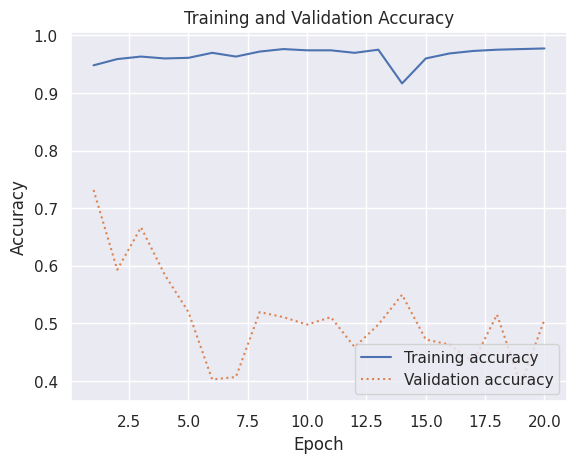

In [ ]:
import matplotlib.pyplot as plt

acc = histLSTM.history['accuracy']
val = histLSTM.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()


En este modelo el accuracy no mejora mucho con el correr de los epochs aunque está desde el principio en niveles altos, e incluso pareciera descender un poquito hacia las ultimas epochs. El score de validacion disminuye hacia la 20ava epoch lo cual seria bueno ya que muestra que la diferencia entre los valores predichos y los reales va disminuyendo con los entrenamientos.

Prediccion

In [ ]:
# Realizar predicción
test_texts = ["neck pain", "running nose and sore throat", "a mosquito bite", "skin rash", "high fever and dizziness"]

for i in test_texts:
    test_sequences = tokenizer.texts_to_sequences([i])
    test_sequences = pad_sequences(test_sequences, maxlen=50, padding='post', truncating='post')

    test_predictions = modelLSTM.predict(test_sequences)
    predicted_class = np.argmax(test_predictions, axis=1)
    predicted_label = label_encoder.inverse_transform(predicted_class)

    print("texto:", i,"\n Especialidad predicha:", predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
texto: neck pain 
 Especialidad predicha: ['cronic disease']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
texto: running nose and sore throat 
 Especialidad predicha: ['dermatology']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
texto: a mosquito bite 
 Especialidad predicha: ['cronic disease']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
texto: skin rash 
 Especialidad predicha: ['dermatology']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
texto: high fever and dizziness 
 Especialidad predicha: ['cronic disease']


## Tensor Flow RNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

x = df["symptoms_tokenized"]
y = df['clasificacion_encoded']

max_words = 20000 # maximo del corpus
max_length = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input, Flatten, Embedding
from tensorflow.keras.utils import to_categorical

num_classes = len(label_encoder.classes_)
labels_tensor = to_categorical(y, num_classes=num_classes)


# Define the RNN model
modelRNN = Sequential()
# Input layer should specify the expected 3D shape for the RNN layer
# The shape is (timesteps, features) - batch size is implicit
modelRNN.add(Input(shape=(max_length, 1)))  # Features dimension added
modelRNN.add(SimpleRNN(50, activation='relu'))
modelRNN.add(Dense(num_classes, activation='softmax'))  # Output layer for classification

# Compile the model
modelRNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

labelsR = to_categorical(y, num_classes=num_classes)

# Train the model
histRNN = modelRNN.fit(x, labelsR, epochs=20, validation_split=0.2)

# Evaluate the model
loss, accuracy = modelRNN.evaluate(x, labelsR, verbose=0)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - accuracy: 0.2692 - loss: 33.1863 - val_accuracy: 0.1429 - val_loss: 44.8352
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.2918 - loss: 12.0268 - val_accuracy: 0.0909 - val_loss: 28.1189
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.3484 - loss: 6.3710 - val_accuracy: 0.1342 - val_loss: 20.5253
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.3338 - loss: 4.5560 - val_accuracy: 0.1212 - val_loss: 18.3248
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3584 - loss: 3.6994 - val_accuracy: 0.1818 - val_loss: 14.5756
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.3662 - loss: 3.3659 - val_accuracy: 0.1645 - val_loss: 12.5484
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.3755 - loss: 2.8599 - val_accuracy: 0.2381 - val_loss: 10.2032
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.3759 - loss: 2.7717 - val_accurac

Visualización

[]

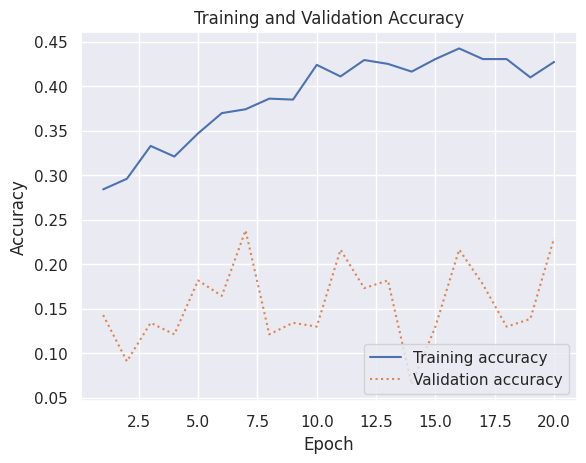

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = histRNN.history['accuracy']
val = histRNN.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

 Bueno, una accuracy bastante pobre, pero ue muestra mejoria con el correr de los epochs, y una validation score muy variable. Veremos como predice nuevos inputs...

Predicción

In [ ]:
# Realizar predicción
test_texts = ["neck pain", "running nose and sore throat", "a mosquito bite", "skin rash", "high fever and dizziness"]

for i in test_texts:
    test_sequences = tokenizer.texts_to_sequences([i])
    test_sequences = pad_sequences(test_sequences, maxlen=50, padding='post', truncating='post')

    test_predictions = modelRNN.predict(test_sequences)
    predicted_class = np.argmax(test_predictions, axis=1)
    predicted_label = label_encoder.inverse_transform(predicted_class)

    print("texto:", i,"\n Especialidad predicha:", predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
texto: neck pain 
 Especialidad predicha: ['gastroenterology']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
texto: running nose and sore throat 
 Especialidad predicha: ['gastroenterology']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
texto: a mosquito bite 
 Especialidad predicha: ['gastroenterology']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
texto: skin rash 
 Especialidad predicha: ['gastroenterology']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
texto: high fever and dizziness 
 Especialidad predicha: ['gastroenterology']


**Conclusionesde de modelos de Deep Learning para el problema de clasificacion:**<br>

En general, a medida que un modelo aprende durante el entrenamiento, el loss value disminuye, porque las predicciones del modelo se parecen más con los datos reales. A medida que el loss value disminuye, el accuracy típicamente aumenta, lo que indica que el modelo está realizando más predicciones correctas.
Sin embargo, esta relación no es estrictamente lineal ni directa: un modelo puede tener un loss value bajo pero aún así tener un accuracy subóptima si está sobreajustando. Lo que significaría que ha aprendido demasiado bien los datos de entrenamiento, incluidos sus ruidos, y no generaliza bien a datos nuevos. Por el contrario, un modelo podría alcanzar un buen accuracy con un loss value más alto si está cometiendo pequeños errores de manera constante en muchas predicciones, en lugar de cometer grandes errores en pocas. <br>

Llevado a mis resultados y predicciones con new inputs, los modelos con embedding, convoluciones y LSTM parecen dar predicciones algo más acertadas que el simple y con RNN.

# Generando texto

Cargo codigo para usar embeddings preentrenado

In [ ]:
%%capture
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2024-12-16 15:41:42--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-12-16 15:41:43--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2024-12-16 15:44:22 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
%%capture
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
import tensorflow as tf
import numpy as np

# ruta al archivo de  GloVe embeddings
glove_file = 'glove.6B.50d.txt'

# cargar el archivo de GloVe embeddings a un diccionario
embeddings_index = {}
with open(glove_file, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings_index[word] = vector

# palabras de muestra para buscar en el GloVe, elegidas a partir de las 50 palabras mas frecuentes de "syntomps_tokenized"
sample_words = ['skin', 'pain', 'fever', 'high', 'neck', 'chest', 'cough', 'headache',
                 'throat', 'rash', 'hurts', 'red', 'severe', 'body', 'back', 'itching',
                 'weak', 'chills', 'like', 'difficult', 'painful', 'frequently', 'coughing',
                 'discomfort', 'stomach', 'nausea', 'uncomfortable', 'occasionally', 'muscles',
                 'lost', 'legs', 'recently', 'exhausted', 'appetite', 'nose', 'trouble',
                 'breathing', 'rashes', 'swollen', 'arms', 'vomiting', 'joints', 'itchy',
                 'pimples', 'sores', 'well', 'stiff', 'night', 'often']

# Crear matriz de embedding para las palabras muestra
embedding_dim = len(embeddings_index['skin'])
embedding_matrix = np.zeros((len(sample_words), embedding_dim))

for i, word in enumerate(sample_words):
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

# Definir la capa de keras con embedding usando el embedding de GloVE
embedding_layer = tf.keras.layers.Embedding(
    len(sample_words),
    embedding_dim,
    weights=[embedding_matrix],
    trainable=False  # poner True para fine-tuneear los embeddings
)


In [ ]:

# ejemplo de uso de uso de capa de embedding
input_data = [sample_words.index(word) for word in sample_words]

# Convertir la lista  a tensor
input_tensor = tf.constant(input_data)

# Pasar el tensor a la capa de embedding
embedded_data = embedding_layer(input_tensor)

print("Sample words:", sample_words)
print("Embedded data:", embedded_data)


Sample words: ['skin', 'pain', 'fever', 'high', 'neck', 'chest', 'cough', 'headache', 'throat', 'rash', 'hurts', 'red', 'severe', 'body', 'back', 'itching', 'weak', 'chills', 'like', 'difficult', 'painful', 'frequently', 'coughing', 'discomfort', 'stomach', 'nausea', 'uncomfortable', 'occasionally', 'muscles', 'lost', 'legs', 'recently', 'exhausted', 'appetite', 'nose', 'trouble', 'breathing', 'rashes', 'swollen', 'arms', 'vomiting', 'joints', 'itchy', 'pimples', 'sores', 'well', 'stiff', 'night', 'often']
Embedded data: tf.Tensor(
[[ 0.6249    0.19755  -0.73095  ... -0.76373  -0.17987   0.038807]
 [ 0.64035   0.095804 -0.73647  ... -0.19688  -0.65308   0.53455 ]
 [ 0.67808   0.10489  -0.64557  ... -0.58355   0.19666  -0.10389 ]
 ...
 [-0.53922  -0.72364  -0.67854  ... -0.23884  -0.37132  -0.089452]
 [ 0.30814   0.47129  -0.27929  ... -0.5908   -0.22165   0.44646 ]
 [ 0.48292  -0.10589  -0.48755  ... -0.1995   -0.25104  -0.17212 ]], shape=(49, 50), dtype=float32)


In [ ]:
# Agregar el índice 0 para el padding (si no se ha hecho ya)
word_index = {k: v+1 for k, v in word_index.items()}  # Esto desplazará todos los índices a partir de 1
word_index['PAD'] = 0  # Asegur que el padding tenga índice 0


# Updatear la matriz de embedding para que incluya todas las palabras tokenizadas
vocab_size = len(word_index) + 1  # Incluyendo  padding tokens
embedding_dim = len(next(iter(embeddings_index.values())))  # 50 for 'glove.6B.50d.txt'

# Crear na matriz de embedding matrix con vocab_size = tokenizer vocabulary size
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i == 0:  # Si el índice es 0 (para padding), no asignamos un vector de embedding
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Asignar vector de embedding de GloVe

In [ ]:
# tarda unos minutos 12:50 a

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# data de muestra para entrenar el modelo de generador de texto
texts = df.symptoms.to_list()

# Tokenizar el texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# Convertir texto  a secuencias
sequences = tokenizer.texts_to_sequences(texts)

# Crear secuencias input y target para text generation
input_sequences = []
target_sequences = []

for sequence in sequences:
    for i in range(1, len(sequence)):
        input_sequences.append(sequence[:i])
        target_sequences.append(sequence[i])

# Padear las secuencias para tener cierta longitud
input_sequences = pad_sequences(input_sequences)

# Instanciar el modelo LSTM para text generation
modelLSTM_G = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,
                              output_dim=embedding_dim,
                              weights=[embedding_matrix],
                              trainable=False),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(len(word_index) + 1, activation='softmax')
])

# Compilar modelo
modelLSTM_G.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

input_sequences_tensor = tf.convert_to_tensor(input_sequences, dtype=tf.int32)
target_sequences_tensor = tf.convert_to_tensor(target_sequences, dtype=tf.int32)


# Entranar modelo
modelLSTM_G.fit(input_sequences_tensor, target_sequences_tensor, epochs=10)


Epoch 1/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - loss: 5.8331
Epoch 2/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - loss: 5.1795
Epoch 3/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - loss: 4.8162
Epoch 4/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - loss: 4.5310
Epoch 5/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 80s 43ms/step - loss: 4.2632
Epoch 6/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 98s 58ms/step - loss: 4.1013
Epoch 7/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 66s 43ms/step - loss: 3.9236
Epoch 8/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - loss: 3.7712
Epoch 9/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - loss: 3.6837
Epoch 10/10
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - loss: 3.5668


In [ ]:
modelLSTM_G.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 55, 50)              │          78,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1576)                │         102,440 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 474,492 (1.81 MB)

 Trainable params: 131,880 (515.16 KB)

 Non-trainable params: 78,850 (308.01 KB)

 Optimizer params: 263,762 (1.01 MB)

In [ ]:
def sample(predictions, temperature=1):
    predictions = np.asarray(predictions).astype('float64')
    predictions = np.log(predictions + 1e-7) / temperature
    predictions = np.exp(predictions) / np.sum(np.exp(predictions))
    return np.random.choice(len(predictions), 1, p=predictions)[0]

#temperature = 0.5: Generará texto más coherente pero menos creativo.
#temperature = 1: Generará texto más diverso, aunque puede ser menos lógico

In [ ]:

# Generar texto usando el modelo entrenado
seed_text = "I've been suffering head "

generated_text = seed_text
max_sequence_length=10
for _ in range(20):
    sequence = tokenizer.texts_to_sequences([generated_text])[0]

    # Padear or truncar la secuencia para que respete la longitud esperada
    sequence = sequence[-max_sequence_length:]
    sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_sequence_length)

    # Convertir a  tensor
    sequence_tensor = tf.convert_to_tensor(sequence, dtype=tf.int32)

    # Predecir probabilida dde proxima palara
    next_word_probs = modelLSTM_G.predict(sequence_tensor, verbose=0)[0]

    # muestra del indice de la proxima palabra
    next_word_index = sample(next_word_probs, temperature=0.2)

    # Encontrar la proxima palabra segun  indice predicho
    next_word = [word for word, index in word_index.items() if index == next_word_index][0]

    generated_text += " " + next_word

print(generated_text)

I've been suffering head  and my skin has been really uncomfortable and my neck has been really uncomfortable and my skin has been really


A partir de mi texto semilla genera un texto que si bien no parece estar muy bien estructurado, se nota que habla de sintomas.

# Conclusiones finales

Se hizo un recorrido por modelos de menor a mayor complejidad para intentar resolver el problema de clasificacion planteado.
Si bien las métricas de los modelos tradicionales de machine learning eran buenas, en la práctica no resuelven bien.
<br>
En los modelos de deep learning, se nota como por ser pequeña la base de deatos, los modelos terminan overfitteando y tampoco resuelven el problema eficientemente.

Futuras líneas serian conseguir una mayor cantidad de observaciones para tener una base más grande donde los modelos puedan tener mejor performance.
Además de revisar la clasificacion inicial de los síntomas en sus enfermedades y post clasificacion en especialidades.

En conjunto creo que es una idea que podria desarrollarse y tendría utilidad en el contexto comercial planteado, optimizando la utilizacion de recursos médicos y la velocidad de atención apropiada para cada paciente.